In [1]:
from transformers import DetrImageProcessor, DetrForObjectDetection
import torch
from PIL import Image
import matplotlib
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from tqdm import tqdm

In [2]:
model_name = 'facebook/detr-resnet-50-dc5'
DETR_PROCESSOR = DetrImageProcessor.from_pretrained(model_name)
DETR_MODEL = DetrForObjectDetection.from_pretrained(model_name).to('cuda')

The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


In [3]:
def get_detr_results(image, processor=DETR_PROCESSOR, model=DETR_MODEL, threshold=0.8):

    inputs = DETR_PROCESSOR(images=image, return_tensors="pt")
    outputs = DETR_MODEL(**inputs.to(model.device))
    
    target_sizes = torch.tensor([image.size[::-1]])
    results = DETR_PROCESSOR.post_process_object_detection(outputs, target_sizes=target_sizes, threshold=threshold)[0]

    return results

In [53]:
def add_bboxes_to_image(
    image,
    detr_results,
    label_size: int = 12,
    line_width: int = 3,
    border_color=(255/255, 75/255, 0/255, 1),
    max_boxes = 10,
    model=DETR_MODEL,
    # hfont = {'fontname':'Times'},
):    
    fig, ax = plt.subplots()
    
    if not isinstance(image, np.ndarray):
        image = np.array(image)
    
    ax.imshow(image)
    ax.axis('off')

    scores = detr_results['scores']
    labels = detr_results['labels']
    bboxes = detr_results['boxes']
    
    for i in range(min(max_boxes, scores.shape[0])):
        score = scores[i].item()
        label = DETR_MODEL.config.id2label[labels[i].item()]
        bbox = bboxes[i].tolist()

        # rectangle
        # top, left, bottom, right = bbox
        left, top, right, bottom = bbox
        adjust = 0 if right < 500 else 42
        rect = patches.Rectangle((left, top), right - left - adjust, bottom - top,
                                 linewidth=line_width,
                                 edgecolor=border_color,
                                 facecolor='none')
        ax.add_patch(rect)

        # label
        bbox_props = dict(boxstyle="square,pad=0",
                          linewidth=line_width, facecolor=border_color,
                          edgecolor=border_color)
        ax.text(left, top, label,
                ha="left", va="bottom", rotation=0,
                size=label_size, bbox=bbox_props)

    return ax

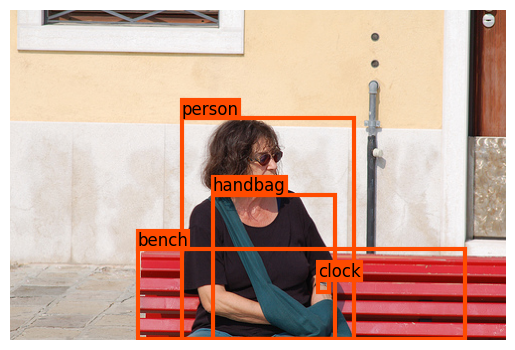

In [54]:
def visualize(
    im_path='./../data/images/247619370.jpg', 
    out_path='./../processed_data/images-detr_resnet_50_dc5/247619370.jpg', 
    threshold=0.8
):
    image = Image.open(im_path)
    detr_results = get_detr_results(image, threshold=threshold)
    ax = add_bboxes_to_image(image, detr_results)

    if out_path is not None:
        plt.savefig(out_path, bbox_inches='tight', pad_inches=0.0)

    return ax

ax = visualize()